# Eigenvalue Counting
with the Landscape potential and box counting neural net

## 1 Architecture and Results
The architectures of the nueral net tries to minic landscape box counting in [arXiv:1909.10558]. The landscape box counting for a potential $V$ and real number $E$ is given as follows. Let $u$ denote the landscape function solving
$$
    (-\Delta+V)u = 1.
$$
on the domain $\Omega$. Let $W=1/u$. Then
$$
n_W(E) = \text{number of cubes, amoung all cubes that tile the domain $\Omega$ with a side length of $E^{−1/2}$ , on which $\inf W \leq E$}
$$
Let $N_V(E)$ denote the true eigenvalue counting for $-\Delta+V$. It has been proved in [arXiv:1909.10558] that
$$
    c_1 n_W( c_2 E) \leq N_V(E) \leq C_3 n_W( C_4 E).
$$
for constants $c_1, c_2$ and $C_3, C_4$.

However, since only upper and lower bounds are provided, no explicit expression is given for $N_V(E)$. One often has to fit the constants. We generalize this fitting in this following neural net work.

There are 2 ingredients:
- <b>Decider.</b> The deciding function: a box is to be counted if $f(W-\mu) :=\inf (W - E) \leq 0$. We generalize this deciding function into a block in our neural net
- <b>BoxCounter.</b> Choosing the approxiate side length $E^{-1/2}$. We simultaneously count on many boxes of various sizes and train the neural net to pick the correct side length

### Decider
This is a residual block that has the following architecture:

In [1]:
# Decider block:
#
# Input -- conv1d --> point-wise product <-- conv1d -- auxiliary input: (W, W^{-1}, W^{-2}, (W')^2 ,etc..)
#  |                     |
#  |                     | conv
#  |                     | 
#  |                     V
#  --------------------> +
#                        |
#                        |
#                        V  
#                     Output

This reason this form is chosen is because eigenvalue counting is sensity to the quantity $W-E$. However, perturbation due to other terms like $W, W^{-1}, W^{-2}, (W')^2$, etc might be important. So in leading order we have a function of $W-E$ while in subleading order we have a product of a function of $W-E$ and all other relavant quantity. The subleading order takes the product form is because semi-classical expansion of the density ressembles this form.

### BoxCounter
BoxCounter has a simple architecture:

In [2]:
# BoxCounter:
#
# Input --> Decider block --> ... --> Decider block --> conv1d --> ... --> conv1d --> Dense --> output
#              |                          |
#              |                          |
#        auxiliary input             auxiliary input

The convolution layers are meant to minic box counting. Instead of having one filter with size $E^{-1/2}$, we use many filters (channels) with a fixed large size. The neural net is to learn the filter's content, which implicitly dictate its "size" (if many entries are 0, the size is small). The many channels are meant to let the neural net count with filters of various sizes. Finally, everything is fed into a dense layer to produced an output, very much like a nonlinear weighted counts from different filters.

### Result
We trained a model of about 77,000 parameters to count eigenvalues of random potentials on a 1D domain of size 1000. There are 200 training potentials each with 20 eigenvalues computed. The list of random potentials are given in randDistri.py.

<b>The mean square error (MSE) is approximately 5.0 after 7 epochs of training and it seems to have stablized.</b>

Example graphs are given at the end of the file

## 2. Import neccessary libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

# Plot
from matplotlib import pylab
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Model

# I/O 
from numpy import loadtxt

## 3. Setting constants

In [4]:
TEST = False

# in this doc
if TEST:
    BATCH_SIZE = 5
    EPOCHS = 1
    PATH='test_data/'
    FILE_NAME = 't'
    PARAMS = [[[10, 5], [20, 5], [30, 5]], 
              [[40, 10, 10, 'same'], [50, 10, 10, 'same'], [60, 10, 10, 'same']],
              [40, 20, 1]]
else:
    BATCH_SIZE = 20
    EPOCHS = 12
    PATH='data/'
    FILE_NAME = 'dos7'
    PARAMS = [[[10, 5], [20, 5], [30, 5]], 
              [[40, 10, 10, 'same'], [50, 10, 10, 'same'], [60, 10, 10, 'same']],
              [40, 20, 1]]

# other relavant parameters
with open(PATH+FILE_NAME+'_params.txt') as f:
    f.readline()
    BOXLENGTH, DATA_SIZE, NEV = list(map(int, f.readline().split(','))) 
NAMES = ['dos', 
         'evs', 
         'W-evs', 'V-evs', 
         'V' 'W', 'W-1', 'W-2', 'DW2', 'W-1DW2', 'W-2DW2', 'V-W', 'WxV-W', 'W2xV-W']

print("Regime:", BOXLENGTH, DATA_SIZE, NEV)
#EPSILON = np.finfo(np.float32).tiny

Regime: 1000 350 100


## 4. Loading training/testing data

In [5]:
def load(names=NAMES, path=PATH, file_name=FILE_NAME):        
    train, test= [], []
    for i in range(len(names)):
        train.append(loadtxt(path + file_name + '_train_' + names[i] + '.cvs', delimiter=',').astype(np.float32))
        test.append(loadtxt(path + file_name + '_test_' + names[i] + '.cvs', delimiter=',').astype(np.float32))
    
    return train, test

# form data for training/testing
# NOTE: cannot set data_size=DATA_SIZE as DATA_SIZE = 0 before loading
def form_data(train, test, data_size=DATA_SIZE, batch_size=BATCH_SIZE): 
    for i in range(len(train)-2):
        train[i+2] = train[i+2][..., tf.newaxis]
        test[i+2] = test[i+2][..., tf.newaxis]
    
    dos_tr, evs_tr, W_tr = train[0], train[1], tf.concat(train[2:4], axis=2)
    aux_tr = tf.concat(train[4:], axis=2)
    
    dos_te, evs_te, W_te = test[0], test[1], tf.concat(test[2:4], axis=2)
    aux_te = tf.concat(test[4:], axis=2)            
    
    train_ds = tf.data.Dataset.from_tensor_slices( \
            (aux_tr, W_tr, evs_tr, dos_tr)).shuffle(data_size).batch(batch_size)
    
    test_ds = tf.data.Dataset.from_tensor_slices( \
            (aux_te, W_te, evs_te, dos_te)).batch(batch_size)
    
    return train_ds, test_ds

def form_test_data(data, data_size=DATA_SIZE): 
    for i in range(len(data)-2):
        data[i+2] = data[i+2][..., tf.newaxis]
        
    dos, evs, W_evs = data[0], data[1], tf.concat(data[2:4], axis=2)
    aux = tf.concat(data[4:], axis=2)
    
    return aux, W_evs, evs, dos


In [6]:
if TEST:
    train_test_data, test_test_data = load()
    print('BOXLENGTH, DATA_SIZE, NEV:')
    print(BOXLENGTH, DATA_SIZE, NEV)
    train_ds, test_ds = form_data(train_test_data, test_test_data) 
    print(train_ds)
    print(np.min(train_test_data[1]))

## 5. Box Counting Function

In [7]:
class Decider(Model):
    def __init__(self, out_channel_size, kernel_size, strides=1):
        super(Decider, self).__init__(name='')
        
        self.FD_conv = layers.Conv1D(out_channel_size, \
                                     kernel_size=kernel_size, \
                                     strides=strides, \
                                     padding='same')
        self.FD_pert_activation = tf.keras.activations.tanh #layers.LeakyReLU()
        self.FD_lead_activation = layers.LeakyReLU(alpha=0.01) # tf.keras.activations.sigmoid  #
        
        self.aux_conv = layers.Conv1D(out_channel_size, \
                                      kernel_size=kernel_size, \
                                      strides=strides, \
                                      padding='same')
        self.aux_activation = tf.keras.activations.tanh #layers.LeakyReLU()
    
    def call(self, aux, W_evs):
        aux = tf.concat([W_evs, aux], axis=2)
        aux = self.aux_conv(aux)
        aux = self.aux_activation(aux)
        
        W_evs = self.FD_conv(W_evs)
        W_evs_pert = self.FD_pert_activation(W_evs)
        W_evs_lead = self.FD_lead_activation(W_evs)
        
        return W_evs_lead + aux * W_evs_pert

In [8]:
if TEST:
    test_decider = Decider(3, 5)
    train_test_data2, _ = load()
    aux, W_evs, evs, dos = form_test_data(train_test_data2)
    print("Aux input shape:", aux.shape)
    print("Decider output shape:",test_decider(aux, W_evs).shape)
    test_decider.summary()

In [9]:
class BoxCounter(Model):
    def __init__(self, decider_params, conv_params, dense_params):
        super(BoxCounter, self).__init__(name='')
        
        self.deciders = []
        self.convs = []
        self.denses = []
        
        for params in decider_params:
            self.deciders.append(Decider(*params))
        
        for filters, kernel_size, strides, padding in conv_params:
            self.convs.append(layers.Conv1D(filters, kernel_size, strides=strides, padding=padding))
            self.convs.append(layers.BatchNormalization())
            self.convs.append(layers.LeakyReLU(alpha=0.01))
        
        for hid_size in dense_params:
            self.denses.append(layers.Dense(hid_size))
            self.denses.append(layers.BatchNormalization())
            self.denses.append(layers.LeakyReLU(alpha=0.01))
    
    def call(self, aux, W_evs):
        for decider in self.deciders:
            W_evs = decider(aux, W_evs)
        
        for layer in self.convs:
            W_evs = layer(W_evs)
        
        # squeeze
        if W_evs.shape[0] != 1:
            W_evs = tf.squeeze(W_evs)
        else:
            W_evs = W_evs[0]
        
        for layer in self.denses:
            W_evs = layer(W_evs)
        
        return W_evs

### Example 1 forward pass

In [10]:
if TEST:
    test_box_counter = BoxCounter(*PARAMS)
    print(test_box_counter(aux, W_evs).shape)
    test_box_counter.summary()

## 7. Training

In [11]:
def train(model, train_ds=None, test_ds=None, epochs=EPOCHS):
    loss_object = tf.keras.losses.MeanSquaredError() #MeanAbsoluteError() #   #MeanAbsolutePercentageError()
    optimizer = tf.keras.optimizers.Adam()
    
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    
    @tf.function
    def train_step(aux, W_evs, target):
        with tf.GradientTape() as tape:
            predictions = model(aux, W_evs)
            loss = loss_object(target, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss(loss)
            
            
    @tf.function
    def test_step(aux, W_evs, target):
        predictions = model(aux, W_evs)
        #print(predictions.shape, target.shape)
        t_loss = loss_object(target, predictions)

        test_loss(t_loss)
    
    

    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        test_loss.reset_states()

        for aux, W_evs, evs, target  in train_ds:
            train_step(aux, W_evs, target)

        for aux, W_evs, evs, target in test_ds:
            test_step(aux, W_evs, target)

        template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            test_loss.result()))

In [12]:
def compare_models(train_ds, test_ds, sample, params, epochs=EPOCHS, nev=NEV, boxlength=BOXLENGTH, model=None):
    
    # defining models
    if not model:
        model = BoxCounter(*params)
    
    # training
    print("-------------------------------------------")
    print("| Starting training for 7_DOSNN")
    print("-------------------------------------------")
    
    train(model, train_ds=train_ds, test_ds=test_ds, epochs=epochs)
    print("")
    print(model.summary())
    print("")
    print("Training finished\n")
    
    
    # displaying some numerical values
    print("-------------------------------------------")
    print("| Displaying numerical values for comparison")
    print("-------------------------------------------")
    print("True DOS:")
    print(sample[-1][:nev])
    print(sample[-2][:nev])
    #print(sample)
    
    
    pred = model(tf.squeeze(sample[0][:nev]), tf.squeeze(sample[1][:nev]))
    print("")
    print("Results from 7_DOSNN")
    print(pred)
    
    return model, sample[-2][:nev], pred
    

In [13]:
train_data, test_data = load()

In [14]:
train_ds, test_ds = form_data(train_data, test_data)
sample = form_test_data(test_data)

In [17]:
model, evs, pred_dos = compare_models(train_ds, test_ds, sample, PARAMS, model=None)

-------------------------------------------
| Starting training for 7_DOSNN
-------------------------------------------
Epoch 1, Training Loss: 32.923336029052734, Test Loss: 5.180811882019043
Epoch 2, Training Loss: 5.536758899688721, Test Loss: 4.453962326049805
Epoch 3, Training Loss: 4.60024356842041, Test Loss: 7.5015668869018555
Epoch 4, Training Loss: 3.8532729148864746, Test Loss: 3.1642680168151855
Epoch 5, Training Loss: 3.372391700744629, Test Loss: 5.455943584442139
Epoch 6, Training Loss: 2.9165337085723877, Test Loss: 3.5340335369110107
Epoch 7, Training Loss: 2.43122935295105, Test Loss: 3.0506041049957275
Epoch 8, Training Loss: 2.3813743591308594, Test Loss: 2.980515241622925
Epoch 9, Training Loss: 2.0542995929718018, Test Loss: 5.70559549331665
Epoch 10, Training Loss: 1.9418631792068481, Test Loss: 3.023064374923706
Epoch 11, Training Loss: 1.736351728439331, Test Loss: 3.7910947799682617
Epoch 12, Training Loss: 1.7201451063156128, Test Loss: 3.017612934112549

Mod

## 8. Visualization

In [18]:
sample_data, _ = load(path='sample_data/', file_name='t')    
aux, W_evs, evs, dos = form_test_data(sample_data)
evs = tf.squeeze(evs)
aux = tf.squeeze(aux)
W_evs = tf.squeeze(W_evs)
dos = tf.squeeze(dos)
pred_dos = model(aux, W_evs)

In [19]:
pred_dos.shape

TensorShape([1100, 1])

BLUE = prediction
ORANGE = true eigenvalue count


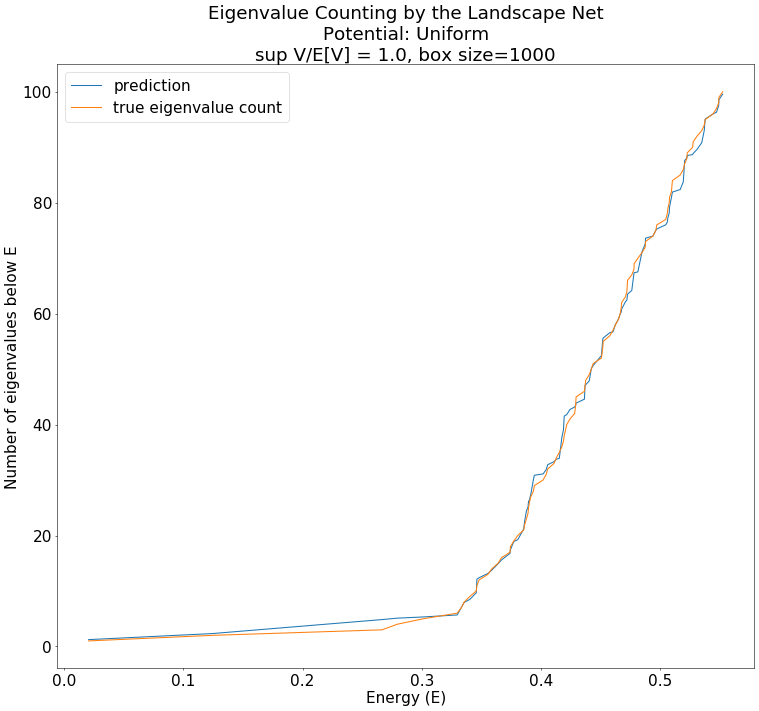

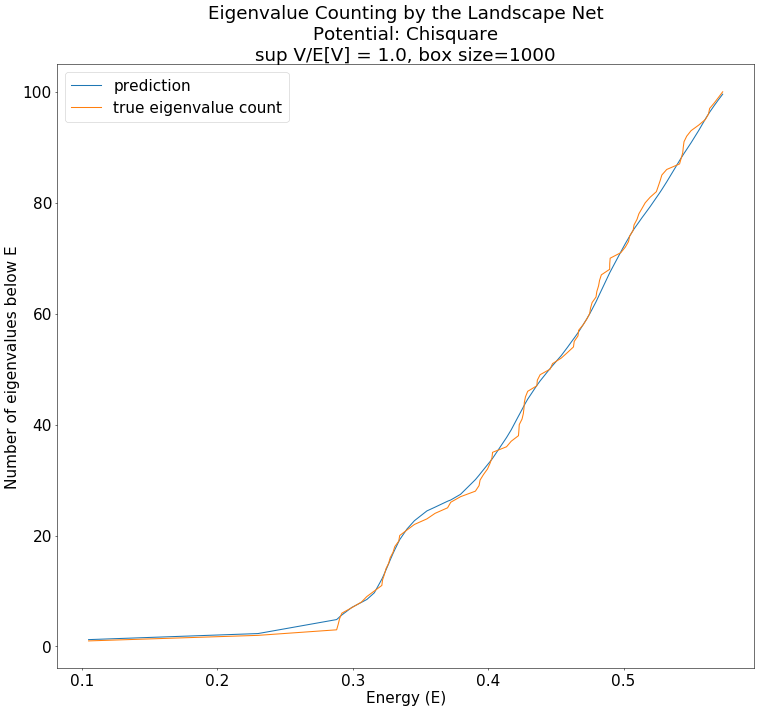

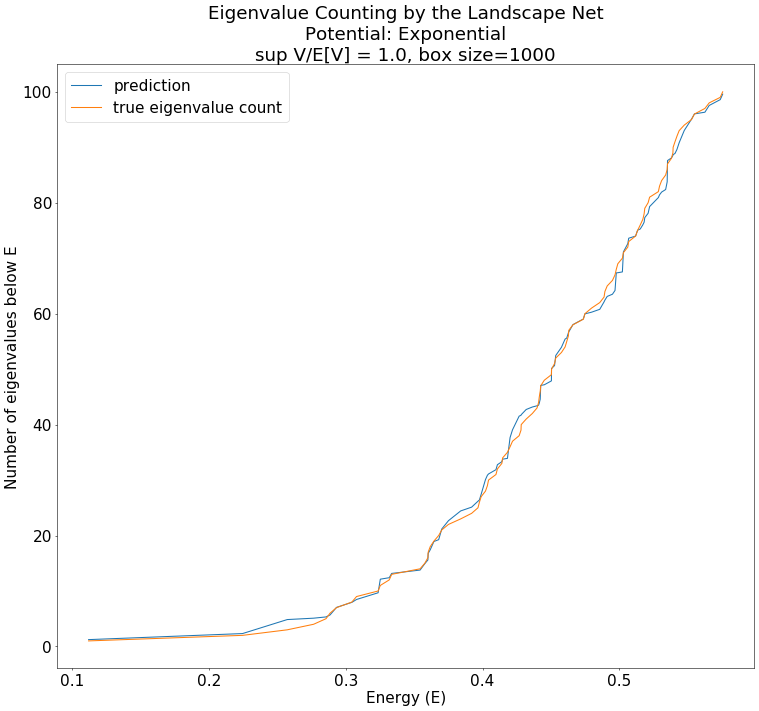

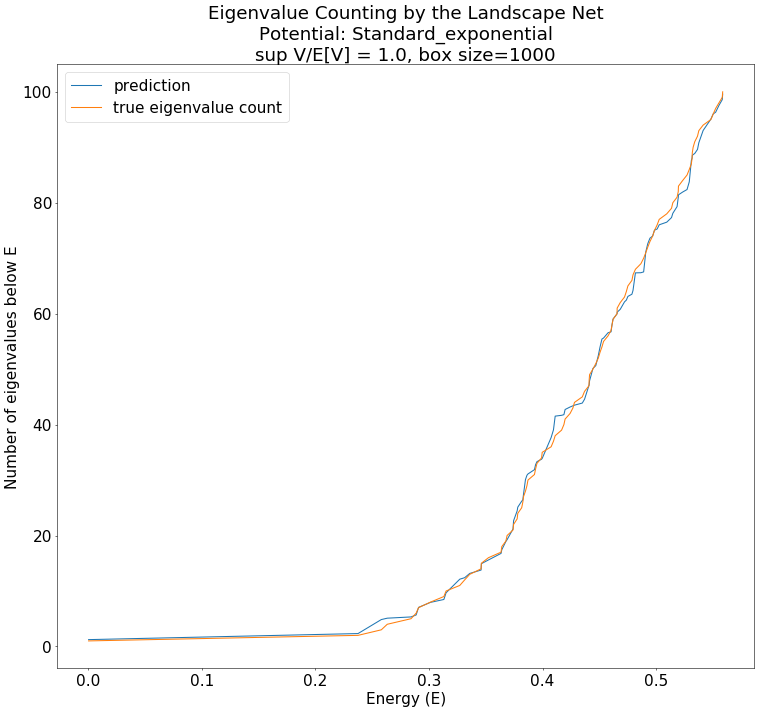

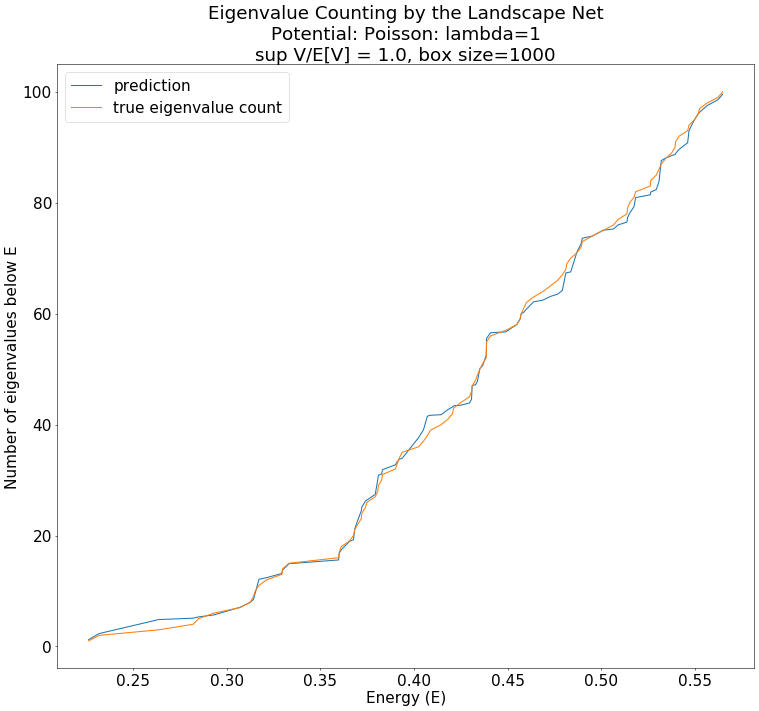

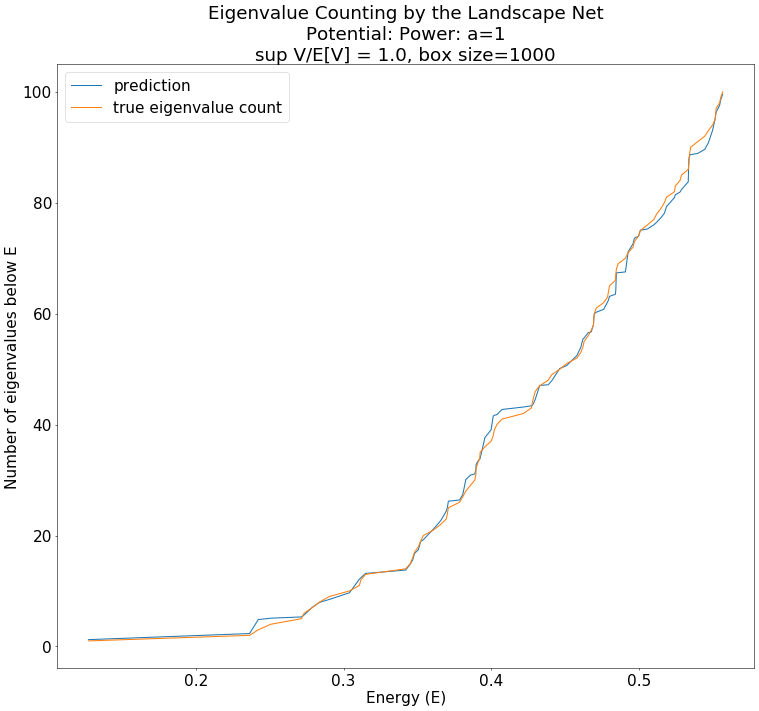

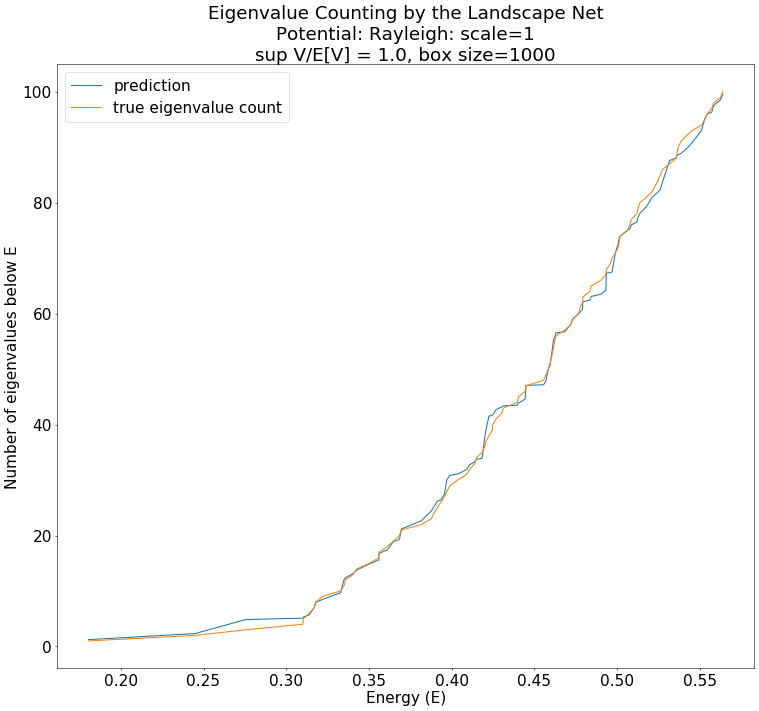

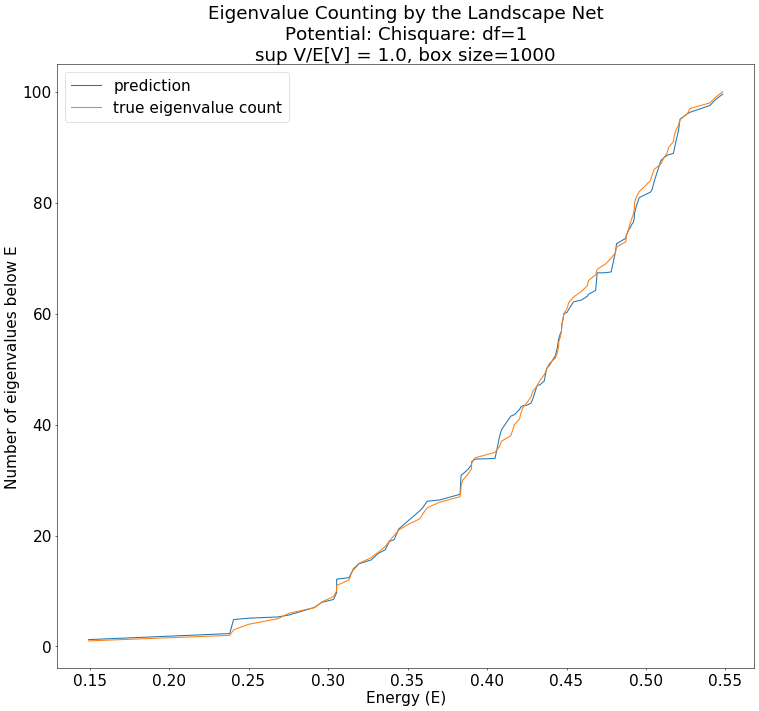

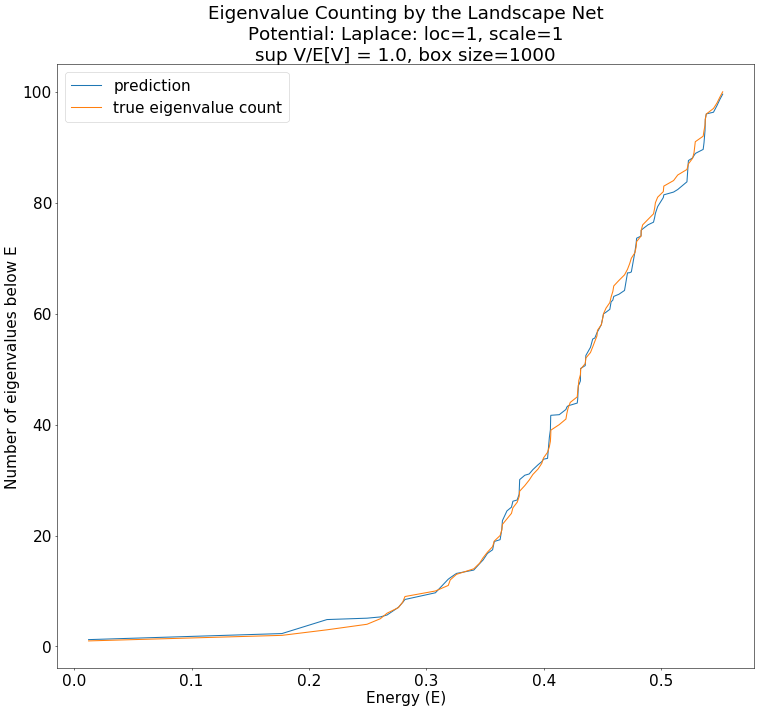

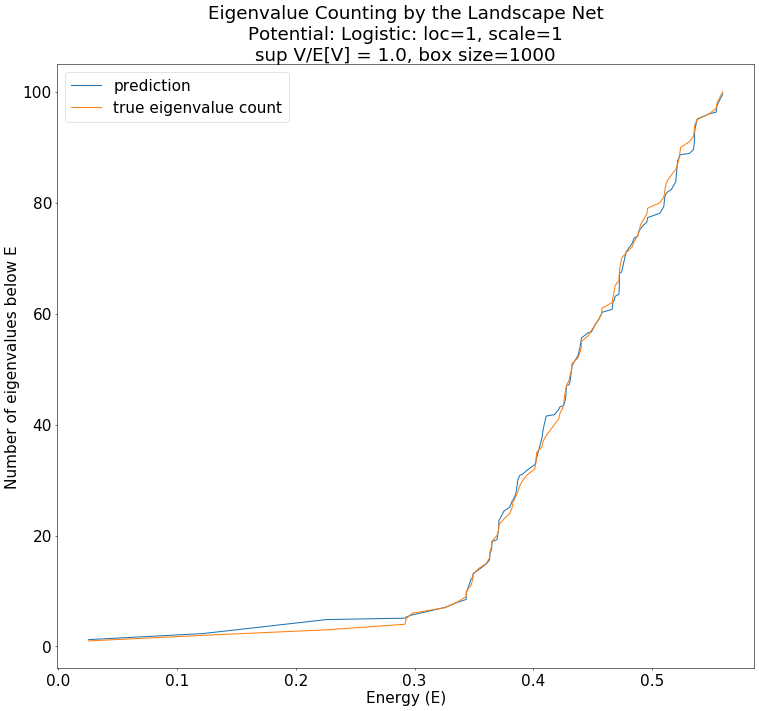

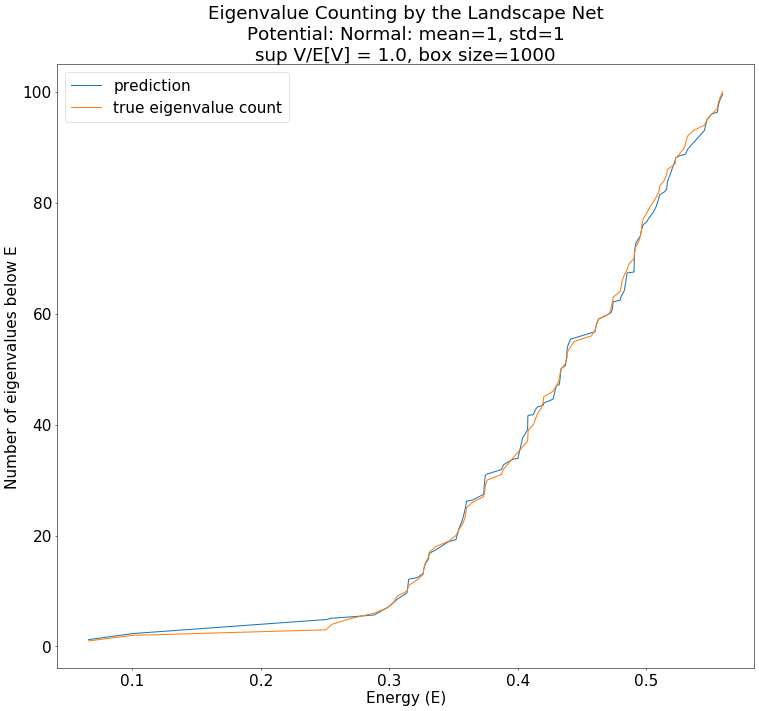

In [20]:
p_str = ['Uniform', 
         'Chisquare',
         'Exponential',
         'Standard_exponential',
         'Poisson: lambda=1',
         'Power: a=1',
         'Rayleigh: scale=1',
         'Chisquare: df=1',
         'Laplace: loc=1, scale=1',
         'Logistic: loc=1, scale=1',
         'Normal: mean=1, std=1'
]

for i in range(len(p_str)):
    p_str[i] = 'Eigenvalue Counting by the Landscape Net\nPotential: ' + p_str[i] + '\nsup V/E[V] = 1.0, box size=1000'
    
    
def plotDOS(k):
    font = {'size'   : 22}

    plt.rc('font', **font)

    fig=plt.figure(figsize=(18, 16), dpi= 50, facecolor='w', edgecolor='k')
    plt.title(p_str[i])
    plt.plot(evs[k*NEV:(k+1)*NEV], pred_dos[NEV:2*NEV], label='prediction')
    plt.plot(evs[k*NEV:(k+1)*NEV], list(range(1, 1+NEV)), label='true eigenvalue count')
    plt.xlabel('Energy (E)')
    plt.ylabel('Number of eigenvalues below E')
    plt.legend()
    plt.show()

print('BLUE = prediction')
print('ORANGE = true eigenvalue count')
for i in range(len(p_str)):
    plotDOS(i)